#### Michaelis-Menten parameters from initial velocity measurements

This is notebook implements a séries of methods for estimation of
Km and Vmax using different types of linear a non-linear regression.
Enter the numnber of substrante concentration values and replicates
and fill the genertaed table by clicking on the cells.

Methods:

- Lineweaver-Burke
- Hanes-Woolfe
- Direct Linear Plot (Eisenthal-Cornish-Bowden)
- Non-Linear fitting (constante relative error)
- Non-Linear fitting (constant variance)

In [1]:
# Import necessary modules
import numpy as np
import pandas as pd
import numpy.random as rnd
from scipy.stats import linregress
import matplotlib.pyplot as plt
from matplotlib import style,rcParams
from seaborn import regplot
from scipy.stats import linregress
style.use('default')
rcParams.update({'axes.grid': True})
rcParams.update({'errorbar.capsize': 2})
pd.options.display.float_format = '{:,.3f}'.format
import ipywidgets as ipyw
import qgrid

In [2]:
# Michaelis-Menten equation
def MM(K,V,s):
  return V*s/(K+s)

In [3]:
# Function to validate input by data type
def check_input(f_type,message):
    """
Wrapper around the input function, reads input
until it matches the required data type. 
    """
    flag = True
    while flag:
        value = input(message)
        try:
            value = f_type(value)
            flag = False
        except ValueError:
            pass
    return value

In [4]:
# Read the number of points and replicates
npoints = check_input(int,"Number of points? ")
nrepl = check_input(int,"Number of replicates? ")

Number of points? 3
Number of replicates? 3


In [5]:
# create an empy pandas data frame with the
# npoint lines and nrepl+1 columns
#
columns = ['[A]']
columns = columns + ['v'+str(i+1) for i in range(nrepl)]
enz_data = pd.DataFrame(np.zeros((npoints, nrepl+1)),columns=columns)
# Create a qgrid table to input the data
qgrid_widget = qgrid.show_grid(enz_data, show_toolbar=False)
qgrid_widget.layout = ipyw.Layout(width='50%')
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [6]:
enz_data = qgrid_widget.get_changed_df()
enz_data['Mean v']=enz_data.iloc[:,1:].mean(axis=1)
enz_data['Std v']=enz_data.iloc[:,1:-1].std(axis=1)
#enz_data['fit_error']=enz_data['Mean v']-MM(Km,Vmax,enz_data['[A]'])
enz_data

,[A],v1,v2,v3,Mean v,Std v
0,1.000,2.000,3.000,4.300,3.100,1.153
1,5.000,4.000,5.600,7.000,5.533,1.501
2,10.000,7.000,8.000,10.000,8.333,1.528


In [7]:
# Get concentrations and velocities from the dataframe
v = np.array(enz_data.iloc[:,1:-2])
s = np.array(enz_data['[A]'])

In [8]:
# Create a pandas dataframa for storing the various estimates
df_estimates = pd.DataFrame(np.zeros((2,4)),index = ['Km','Vmax'],columns=['L-B','H-W','E-CB','JL'])
df_estimates

,L-B,H-W,E-CB,JL
Km,0.000,0.000,0.000,0.000
Vmax,0.000,0.000,0.000,0.000


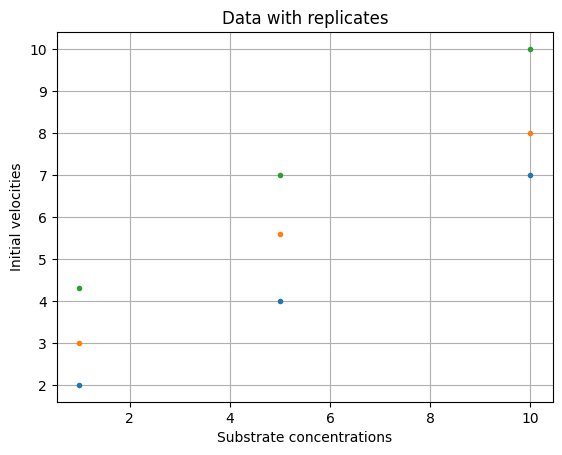

In [9]:
#### Untransformed data with replicates
plt.title("Data with replicates")
plt.xlabel("Substrate concentrations")
plt.ylabel("Initial velocities")
#plt.ylim(0,1.1*Vmax)
plt.plot(s,v,'.');

Text(0.5, 1.0, 'Michaelis-Menten Plot with error bars')

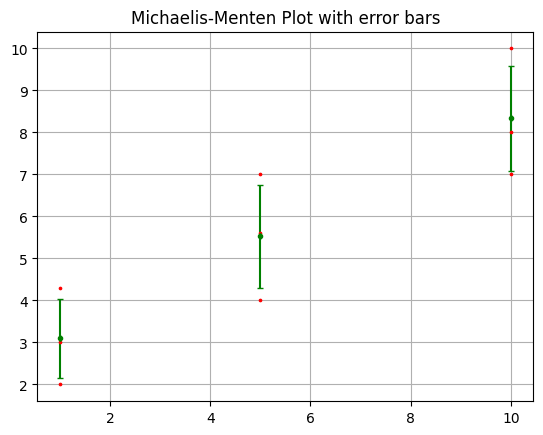

In [10]:
# Michaelis-Menten direct plot with error bars
plt.plot(s,v,'r.',ms=3.3)
plt.errorbar(s,v.mean(axis=1),fmt='g.',xerr=0.0,yerr=v.std(axis=1),capsize=2)
plt.title("Michaelis-Menten Plot with error bars")

Lineweaver-Burke estimates:
    Km = 1.750, Vmax= 8.462, R2 = 0.9625


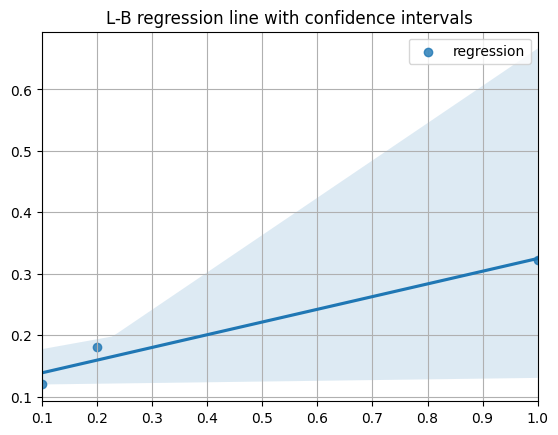

In [12]:
# Lineweaver-Burke regression with confidence intervals
from seaborn import regplot
vlb = v[:,0]
vlb = v.mean(axis=1)
regplot(1/s,1/vlb,label="regression")
m, b,r,_,_ = linregress(1/s,1/vlb)
_ = plt.title("L-B regression line with confidence intervals")
plt.legend()
LB_Km = m/b
LB_Vmax = 1/b
print("Lineweaver-Burke estimates:")
print("    Km = {:5.3f}, Vmax= {:5.3f}, R2 = {:.4f}".format(LB_Km,LB_Vmax,r*r))
df_estimates['L-B'] = LB_Km,LB_Vmax

Hanes-Woolf estimats:
    Km = 3.098, Vmax= 10.425, R = 0.9691


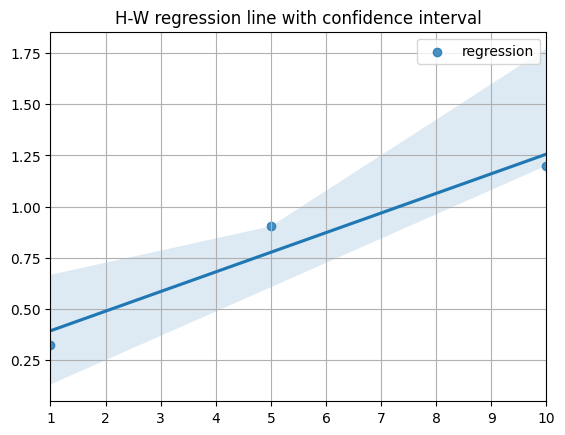

In [15]:
# Hanes-Woolf regression with confidence interval
shw = s
vhw = v.mean(axis=1)
#vhw = v[:,0]
vhw = s / vhw
regplot(s,vhw,label="regression")
m, b,r,_,_ = linregress(s,vhw)
_ = plt.title("H-W regression line with confidence interval")
plt.legend()
#print(m,b,r)
#print(1/m,b/m)
HW_Km = b/m
HW_Vmax = 1/m
print("Hanes-Woolf estimats:")
print("    Km = {:5.3f}, Vmax= {:5.3f}, R = {:.4f}".format(HW_Km,HW_Vmax,r))

df_estimates['H-W'] = HW_Km, HW_Vmax

Computing 3 intersections
Direct Linear plot estimates:
    Km = 2.309, Vmax= 10.257


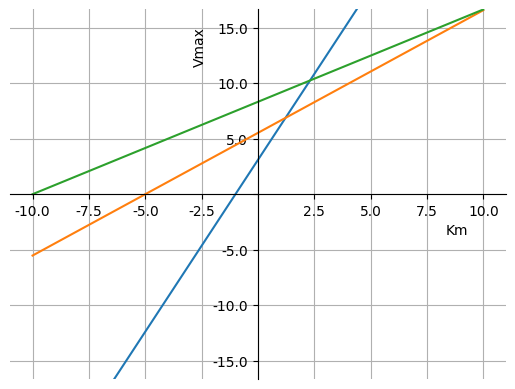

In [16]:
# Eisenthal Cornish-Bowden direct linear plot
vm = v.mean(axis=1)
x = np.arange(-s.max(),s.max(),0.01)
int_Vmax = []
int_Km = []
mmlines = np.vstack((vm/s,vm)).T
n_int = len(s)*(len(s)-1)//2
#Km_int = np.zeros(n_int)
#Vmax_int = np.zeros(n_int)

for m, b in mmlines:
  plt.plot(x,m*x+b)

print("Computing {:d} intersections".format(n_int))
for i in range(mmlines.shape[0]):
  for j in range(i):
    m1, b1 = mmlines[i]
    m2, b2 = mmlines[j]
    x = (b2-b1)/(m1-m2)
    y = (b2*m1-b1*m2)/(m1-m2)
    int_Km.append(x)
    int_Vmax.append(y)
    #print(x,y)
    #pass
    #print(i,j,mmlines[i],mmlines[j])rray python

ax = plt.gca()
ax.axis([-1.1*s.max(),1.1*s.max(),-2*vm.max(),2*vm.max()])
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xlabel("Km",x=0.9)
ax.set_ylabel("Vmax",y=0.9)

# Remove zeros on x an y axis
import matplotlib.ticker as ticker
func = lambda x, pos: "" if np.isclose(x,0) else x
ax.xaxis.set_major_formatter(ticker.FuncFormatter(func))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(func))

ECB_Km = np.median(int_Km)
ECB_Vmax = np.median(int_Vmax)
print("Direct Linear plot estimates:") 
print("    Km = {:5.3f}, Vmax= {:5.3f}".format(ECB_Km, ECB_Vmax))
df_estimates['E-CB'] = ECB_Km, ECB_Vmax

##### Non-Linear Regression methods

Exact non-linear estimates at constant relative error:
    Km = 2.066, Vmax= 9.225


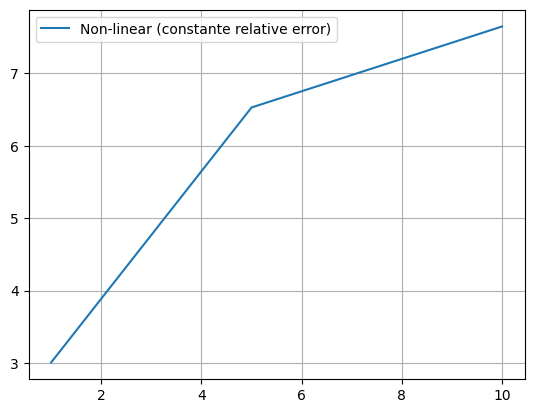

In [19]:
# Non-linear least square fitting (constant relative error)
# Johansen and Lumry
D = (vm*vm / s / s).sum()*vm.sum()-(vm*vm/s).sum()*(vm/s).sum()
JL_Vmax = ((vm*vm / s / s).sum()*(vm*vm).sum()-((vm*vm/s).sum())**2) / D
JL_Km = ((vm*vm).sum()*(vm/s).sum()-(vm*vm/s).sum()*vm.sum()) / D
plt.plot(s,MM(JL_Km,JL_Vmax,s),label = "Non-linear (constante relative error)")
plt.legend()
print("Exact non-linear estimates at constant relative error:")
print("    Km = {:5.3f}, Vmax= {:5.3f}".format(JL_Km, JL_Vmax))
df_estimates['JL'] = JL_Km, JL_Vmax

In [20]:
df_estimates

,L-B,H-W,E-CB,JL
Km,1.750,3.098,2.309,2.066
Vmax,8.462,10.425,10.257,9.225


The error in the estimates is computed using the experimental variance:

$$ \sigma_{exp}^2 = \frac{\widehat{SS}}{(n-2)}$$

where $\widehat{SS}$ is the weighted sum of squares:

$$ \widehat{SS} = \sum w (1/v-1/\hat v)^2  $$

for constant relative error the weights are $w_i = v_i^2$, and for constant error they are $ w_i = \hat v^3v$ .

In [ ]:
# Compute the experimental variance
v_hat = MM(JL_Km, JL_Vmax,s)
exp_var = (vm*vm*(1/vm - 1/v_hat)**2).sum() / (npoints-2) 
Vmax_var = (JL_Vmax)**4 * exp_var**2 * (vm*vm / s / s).sum() 
Vmax_var = Vmax_var / ((vm*vm / s / s).sum() * (vm*vm).sum() - ((vm*vm/s).sum())**2)           
Vmax_var

In [ ]:
(((1/vm - 1/v_hat)**2)*vm*vm).sum() / 8

In [ ]:
 D = (vm*vm / s / s).sum()*vm.sum()-(vm*vm/s).sum()*(vm/s).sum()

In [ ]:
B = (vm*vm).sum()*(vm/s).sum()-(vm*vm/s).sum()*vm.sum()

In [ ]:
#A/D,B/D